In [2]:
%matplotlib inline

In [4]:
!pip install torchvision

  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 3.6MB 91kB/s 
  Found existing installation: Pillow 3.3.1
    Uninstalling Pillow-3.3.1:
      Successfully uninstalled Pillow-3.3.1
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.




Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data







In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let us show some of the training images, for fun.



 deer  bird  frog   cat


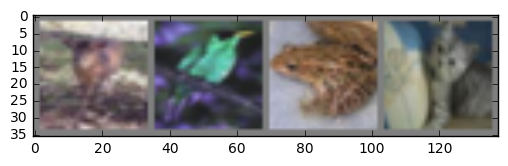

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the network




In [15]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.217
[1,  4000] loss: 1.206
[1,  6000] loss: 1.206
[1,  8000] loss: 1.185
[1, 10000] loss: 1.185
[1, 12000] loss: 1.167
[2,  2000] loss: 1.113
[2,  4000] loss: 1.113
[2,  6000] loss: 1.116
[2,  8000] loss: 1.120
[2, 10000] loss: 1.099
[2, 12000] loss: 1.099
[3,  2000] loss: 1.031
[3,  4000] loss: 1.036
[3,  6000] loss: 1.043
[3,  8000] loss: 1.050
[3, 10000] loss: 1.047
[3, 12000] loss: 1.038
[4,  2000] loss: 0.948
[4,  4000] loss: 0.958
[4,  6000] loss: 0.997
[4,  8000] loss: 0.980
[4, 10000] loss: 0.996
[4, 12000] loss: 1.019
Finished Training


Test the network on the test data




GroundTruth:    cat  ship  ship plane


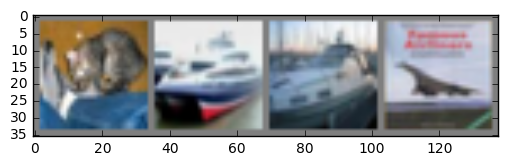



Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %




Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    print("size of class:"+str(class_total[i]))

Accuracy of plane : 61 %
size of class:1000.0
Accuracy of   car : 75 %
size of class:1000.0
Accuracy of  bird : 54 %
size of class:1000.0
Accuracy of   cat : 43 %
size of class:1000.0
Accuracy of  deer : 56 %
size of class:1000.0
Accuracy of   dog : 57 %
size of class:1000.0
Accuracy of  frog : 71 %
size of class:1000.0
Accuracy of horse : 61 %
size of class:1000.0
Accuracy of  ship : 81 %
size of class:1000.0
Accuracy of truck : 68 %
size of class:1000.0
